# Multi-armed Bandits

This chapter presents several simple methods that perform the exploitation-exploration balancing act for the multi-armed or *k*-armed bandit problem.

The $k$-armed bandit problem is defined as follows:

> You are faced repeatedly with a choice among $k$ different options, or actions. After each choice you receive a numerical reward chosen from a stationary probability distribution that depends on the action you selected. Your objective is to maximize the expected total reward over some time period, for example, over 1000 action selections or _time steps_.

It is a _nonassociative task_.

## Definitions

**Nonassociative Tasks**: One situation. There is _no need to associate different actions with different situations_. In these tasks, the learner either tries to find a single best action when the task is stationary, or tries to track the best action as it changes over time when the task is nonstationary.

**Associative Tasks**: More than one situation and the goal is to learn a policy (mapping from situations to the actions that are best in those situations).

**Greedy Action**: The action $a$ that has highest estimated value $Q_t(a)$. Selecting the greedy action exploits the agents current knowledge of the values of each action.

**Action-value Methods**: Methods that estimate the values of actions and for using the estimates to make action selection decisions.

**$\epsilon$-greedy Methods**: Methods that select the greedy action most of the time but ocassionally, with small probability $\epsilon$, select randomly from among all actions with equal probability.

## Notation

$t$: The time step.

$A_t$: The action selected on time step $t$.

$R_t$: The reward given action $A_t$ was selected.

$q_*(a) = \mathbb{E}[R_t \mid A_t = a]$: The value (expected reward) of an arbitrary action $a$.

$Q_t(a)$: The estimated value of action $a$ at time step $t$.

## Action-value Methods

### Sample-average Methods

The true value of an action is the mean reward when that action is selected. A natural estimate for this is to average the rewards that have actually been received:

\begin{align*}
    Q_t(a)
        &\dot{=} \frac{\text{sum of rewards when $a$ taken prior to $t$}}
                      {\text{number of times $a$ taken prior to $t$}} \\
        &= \frac{\sum_{i = 1}^{t - 1} R_i \cdot \mathbb{1}_{A_i = 1}}
                {\sum_{i = 1}^{t - 1} \mathbb{1}_{A_i = 1}}
\end{align*}

If the denominator is 0 then $Q_t(a)$ is defined as a default value such as 0.

As the denominator goes to infinity, by the law of large numbers, $Q_t(a)$ converges to $q_*(a)$.

The simplest action selection rule spends no time exploring and simple selects the greedy action:

$$
A_t \dot{=} \text{argmax}_a Q_t(a)
$$

A simple alternative is to behave greedily most of the time but with occasionally, with small proability $\epsilon$, select randomly from among all actions with equal probability.

In the limit as the number of steps increases every action will be sampled an infinite number of times thus ensuring that all $Q_t(a)$ converge to $q_*(a)$. This asymptotic guarantee says little about the practical effectiveness of the methods.

The code below implements a 10-_armed testbed_ to evaluate the practical effectiveness.

In [1]:
import matplotlib.pyplot as plt
import torch

# configure matplotlib to look nicer
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = 10, 6

In [2]:
class BanditProblem(torch.utils.data.IterableDataset):
    def __init__(self, arms=10, runs=1, device=torch.device("cpu")):
        super().__init__()
        self.runs = runs
        self.action_vals = torch.empty(runs, arms, device=device).normal_()
        # indices of optimal action (max expected value)
        self.optimal = torch.argmax(self.action_vals, dim=1)
        self.device = device
        
    def __iter__(self):
        return self
        
    def __next__(self):
        return torch.normal(self.action_vals, torch.ones_like(self.action_vals))

In [3]:
bp = BanditProblem()

In [4]:
n_samples = 1000
means = bp.action_vals[0].expand(n_samples, -1).T
stds = torch.ones_like(means)
vals = torch.normal(means, stds)

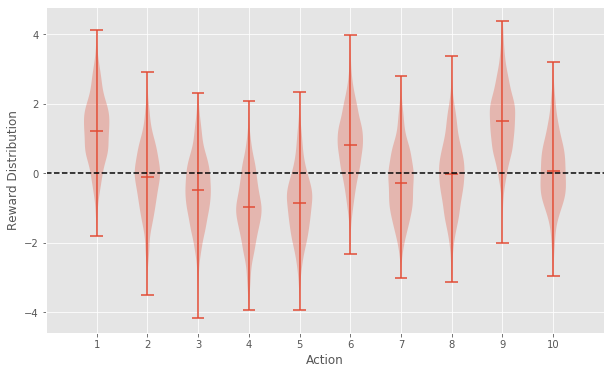

In [5]:
plt.violinplot(dataset=vals, showmeans=True)

plt.hlines(y=0, xmin=0, xmax=11, linestyles='dashed')

plt.xlabel("Action")
plt.ylabel("Reward Distribution")

plt.xlim(0, 11)

plt.xticks(ticks=list(range(1, 11)))

plt.show()

In [46]:
class EpsilonAgent(torch.nn.Module):
    def __init__(self, arms=10, runs=1, epsilon=0.0):
        super().__init__()
        self.epsilon = epsilon
        self.arms = arms
        self.runs = runs
        self.register_buffer("action_rewards", torch.zeros(runs, arms))
        self.register_buffer("action_counts", torch.zeros(runs, arms, dtype=torch.int32))
        self.register_buffer("time_step", torch.tensor(0))
        
    def forward(self, x):
        explore = torch.randint(low=0, high=self.arms, size=(self.runs,), dtype=torch.long, device=x.device)
        exploit = torch.argmax(
            self.action_rewards / 
                torch.max(
                    self.action_counts.float(), 
                    torch.tensor(1, dtype=torch.float, device=x.device)
                ),
            dim=1
        )

        if self.time_step == 0:
            choice = torch.zeros(self.runs, dtype=torch.bool, device=x.device)
        else:
            choice = torch.rand(self.runs, device=x.device) < self.epsilon
            
        actions = torch.where(choice, explore, exploit)
        
        counts = torch.gather(
            self.action_counts, dim=1, index=actions.view(-1, 1)
        )
        action_rewards = torch.gather(
            self.action_rewards, dim=1, index=actions.view(-1, 1)
        )
        actual_rewards = torch.gather(
            x, dim=1, index=actions.view(-1, 1)
        )
        
        self.action_counts.scatter_(
            src=counts + 1, dim=1, index=actions.view(-1, 1)
        )
        self.action_rewards.scatter_(
            src=action_rewards + actual_rewards, dim=1, index=actions.view(-1, 1)
        )
        self.time_step += 1
        
        return actions

In [47]:
def simulate(agent, runs, time_steps, log_every=1, device=torch.device("cpu"), jit=False):
    agent.to(device)
    if jit:
        agent = torch.jit.script(agent)
    bp = BanditProblem(runs=runs, device=device)

    agent_rewards = torch.zeros(time_steps // log_every, bp.runs, device=device)
    agent_actions = torch.zeros(time_steps // log_every, bp.runs, dtype=torch.long, device=device)
    
    optimal = torch.zeros(time_steps // log_every, bp.runs, dtype=torch.long, device=device)

    for t, rewards in enumerate(bp):
        if t == time_steps:
            break

        actions = agent(rewards)
        
        if t % log_every == 0:   
            opt = actions == bp.optimal
            rewards = torch.gather(
                rewards, dim=1, index=actions.view(bp.runs, 1)
            )[:, 0]
            agent_actions[t // log_every] = actions
            optimal[t // log_every] = opt
            agent_rewards[t // log_every] = rewards
        
    steps = torch.arange(start=1, end=agent_rewards.size(0) + 1, device=device).expand(runs, -1).T
    
    average_reward = (torch.cumsum(agent_rewards, dim=0) / steps).mean(dim=1)
    # initialize average reward to zero
    average_reward = torch.cat((torch.tensor([0.], device=device), average_reward))
    
    opt_freq = (torch.cumsum(optimal, dim=0).float() / torch.max(steps, torch.tensor(1, device=device))).mean(dim=1)
    opt_freq = torch.cat((torch.tensor([0.], device=device), opt_freq))
    
    return average_reward, opt_freq

In [54]:
arms = 10
runs = 2000
time_steps = 1e6
log_every = 1e3

results = {}
for eps in [0.0, 0.01, 0.1]:
    print(eps)
    eps_results = simulate(
        agent=EpsilonAgent(arms, runs, eps), 
        runs=runs, 
        time_steps=time_steps,
        log_every=log_every,
        device=torch.device("cuda:0"),
        jit=True
    )
    results[eps] = (r.cpu() for r in eps_results)

0.0
0.01
0.1


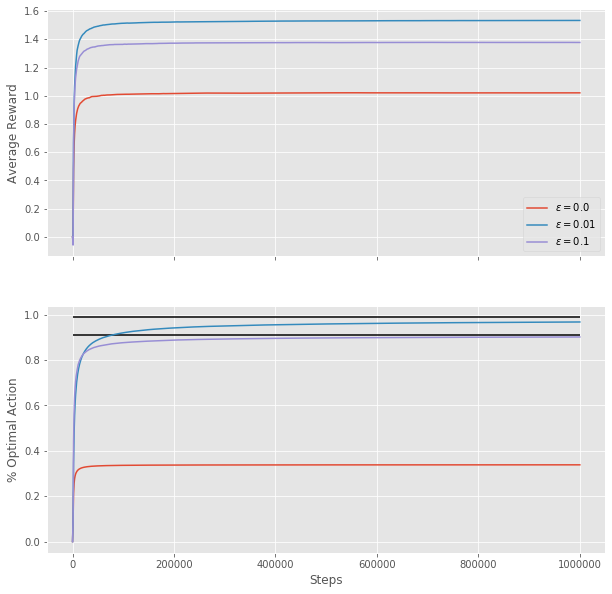

In [55]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10, 10))

for eps, (avg_reward, opt_freq) in results.items():
    x = range(0, time_steps + 1, log_every)
    ax1.plot(x, avg_reward, label=f"$\epsilon={eps}$")
    ax2.plot(x, opt_freq)
    
    if eps == 0:
        continue
    ax2.hlines(y=(1.0 - eps) + eps**2, xmin=0, xmax=time_steps)
    
ax1.set_ylabel("Average Reward")
ax2.set_xlabel("Steps")
ax2.set_ylabel("% Optimal Action")

ax1.legend()
plt.show()